In [2]:
import os
import random
import urllib.request
import tarfile
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Oxford-IIIT Pet 데이터셋의 URL과 다운로드 경로 지정
DATA_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANNOTATIONS_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
DATA_DIR = "./oxford_pets_data"

# 데이터셋 다운로드 및 압축 해제 함수
def download_and_extract_data(url, dest_dir, archive_name):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    tar_path = os.path.join(dest_dir, archive_name)

    if not os.path.exists(tar_path):
        print(f"Downloading {archive_name}...")
        urllib.request.urlretrieve(url, tar_path)
        print(f"Download of {archive_name} complete.")

    print(f"Extracting {archive_name}...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=dest_dir)
    print(f"Extraction of {archive_name} complete.")

# Pet 데이터셋을 PyTorch에서 사용하는 Dataset 형식으로 정의
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, labels_file, split="train", transform=None):
        self.images_dir = images_dir
        self.split = split
        self.transform = transform
        self.image_paths, self.labels = self.load_annotations(labels_file)

    def load_annotations(self, labels_file):
        with open(labels_file, "r") as f:
            lines = f.readlines()

        image_paths = []
        labels = []
        for line in lines:
            parts = line.strip().split(" ")
            image_paths.append(parts[0] + ".jpg")
            labels.append(int(parts[1]) - 1)  # 레이블은 1부터 시작하므로 0부터 시작하도록 변환

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# 시드 설정
set_seed(42)

# 데이터 다운로드
print("Downloading and extracting dataset...")
download_and_extract_data(DATA_URL, DATA_DIR, "images.tar.gz")
download_and_extract_data(ANNOTATIONS_URL, DATA_DIR, "annotations.tar.gz")

# 경로 설정
images_dir = os.path.join(DATA_DIR, "images")
annotations_file = os.path.join(DATA_DIR, "annotations", "trainval.txt")

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(p=0.5),  # 랜덤 가로 반전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # 이미지를 텐서로 변환
])

# 전체 데이터셋 로드
full_dataset = OxfordPetsDataset(images_dir, annotations_file, split="train", transform=transform)

# Train/Validation 데이터 split
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)  # 고정된 시드 기반으로 데이터 분할
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Test 데이터셋 정의
test_annotations_file = os.path.join(DATA_DIR, "annotations", "test.txt")
test_dataset = OxfordPetsDataset(images_dir, test_annotations_file, split="test", transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 확인
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Download of images.tar.gz complete.
Extracting images.tar.gz...
Extraction of images.tar.gz complete.
Download of annotations.tar.gz complete.
Extracting annotations.tar.gz...
Extraction of annotations.tar.gz complete.
Train Dataset Size: 3312
Validation Dataset Size: 368
Test Dataset Size: 3669


In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_p=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),  # Dropout 추가
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# 모델 초기화|
num_classes = len(set(full_dataset.labels))
model = ResNet18(num_classes=num_classes, dropout_p=0.3)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 학습 및 검증 손실 시각화를 위한 그래프 그리기 함수
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

# 학습 함수 (로그 출력 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)

        # Validation 단계
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

    return train_losses, val_losses


In [13]:
# 테스트 함수
def test_model(model, test_loader, criterion, device="cpu"):
    model.to(device)
    model.eval()  # 평가 모드로 설정
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total

    print("Test Results")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%\n")

    return test_loss, test_acc


Training the model...
Epoch [1/50]
Training Loss: 3.7519, Training Accuracy: 3.53%
Validation Loss: 3.6955, Validation Accuracy: 5.71%

Epoch [2/50]
Training Loss: 3.5846, Training Accuracy: 5.25%
Validation Loss: 4.1257, Validation Accuracy: 5.16%

Epoch [3/50]
Training Loss: 3.4650, Training Accuracy: 6.97%
Validation Loss: 3.6144, Validation Accuracy: 4.89%

Epoch [4/50]
Training Loss: 3.4022, Training Accuracy: 7.67%
Validation Loss: 3.8691, Validation Accuracy: 5.71%

Epoch [5/50]
Training Loss: 3.3282, Training Accuracy: 8.45%
Validation Loss: 3.6756, Validation Accuracy: 7.88%

Epoch [6/50]
Training Loss: 3.2567, Training Accuracy: 10.21%
Validation Loss: 3.3633, Validation Accuracy: 11.96%

Epoch [7/50]
Training Loss: 3.1949, Training Accuracy: 11.35%
Validation Loss: 3.3817, Validation Accuracy: 7.61%

Epoch [8/50]
Training Loss: 3.1498, Training Accuracy: 12.20%
Validation Loss: 3.2941, Validation Accuracy: 10.60%

Epoch [9/50]
Training Loss: 3.0888, Training Accuracy: 14.70%

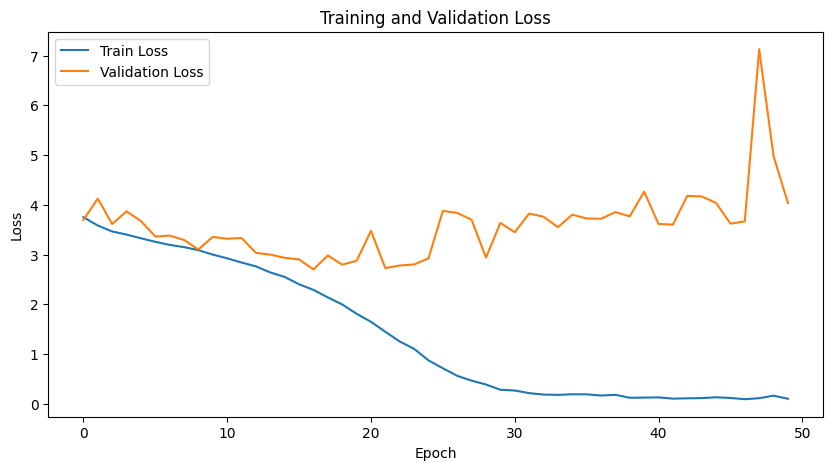

In [14]:
# 학습 및 검증 실행
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 50

# 학습 시작
print("Training the model...")
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# 학습 손실 그래프 출력
plot_loss(train_losses, val_losses)


In [15]:
# 테스트 실행
print("Testing the model...")
test_loss, test_acc = test_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)


Testing the model...
Test Results
Test Loss: 4.5527
Test Accuracy: 30.28%



##The Oxford-IIIT Pet Dataset

###데이터셋 특징
- 37개 품종의 반려동물 이미지
  - 고양이 : 12개
  - 강아지 : 25개

- 이미지 수 : 총 7349장의 이미지
  - 품종마다 약 200장 이상의 이미지

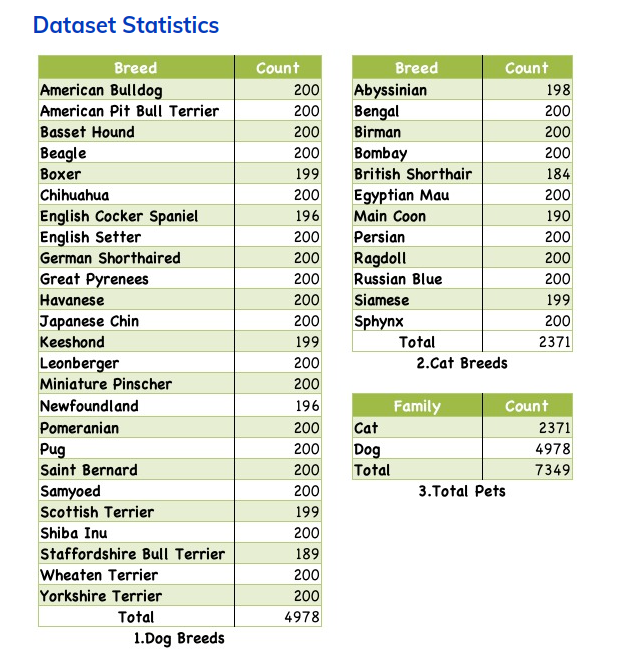



- 두 개의 별도 파일
  - images.tar.gz (Dataset)
      - 실제 이미지 데이터
  - annotations.tar.gz (Ground Truth Data)
    - 레이블 정보, 세그멘테이션 마스크, bounding box

- 활용
  - Classification
  - Segmentation
  - Detection


### 특이 사항  
1. **데이터셋 구성**:  
   - Oxford-IIIT Pet 데이터셋을 활용하였습니다.  
   - Train/Validation/Test 세트를 생성하는 과정에서 고정된 랜덤 시드를 사용하여 재현 가능성을 확보했습니다.  

2. **모델 구조**:  
   - ResNet-18을 구현하였으며, Dropout을 추가하였습니다.

3. **변환(Transform)**:  
   - 데이터 증강을 위해 `RandomHorizontalFlip`, `ColorJitter` 등을 사용하여 학습 데이터를 다양화했습니다.  

4. **학습 결과**:  
   - 학습 초기에는 손실 감소와 정확도 상승이 확인되었으나, 후반부에는 검증 정확도가 학습 정확도에 비해 낮아지는 과적합 현상이 관찰되었습니다.  

---

### 어려웠던 점  
1. **데이터셋 로드 및 전처리**:  
   - Oxford-IIIT Pet 데이터셋의 구조를 이해하고, 각 이미지를 적절히 불러오는 과정에서 시간이 소요되었습니다.  

2. **검증 정확도 정체**:  
   - 학습 후반부에서 Validation Loss가 크게 개선되지 않는 문제가 나타났습니다. 모델의 일반화 능력을 향상시키기 위해 추가적인 데이터 증강 기법이나 LR 스케줄링이 필요하다고 생각합니다.

---

### 분석 및 고찰  
1. **성능 분석**:  
   - 최종 학습 결과, Training Accuracy는 약 94% 이상 도달했으나 Validation Accuracy는 33% 내외로 과적합이 확인되었습니다.  
   - 데이터셋 자체의 클래스 불균형이 모델 성능에 영향을 미쳤을 가능성이 큽니다. 이를 해결하기 위해 클래스 가중치 또는 Oversampling 기법을 사용할 수 있을 것입니다.  

2. **모델 개선 가능성**:  
   - Dropout 외에 Batch Normalization, Learning Rate Decay 등의 방법 사용을 고려해야 합니다.

3. **데이터셋 최적화**
   - 데이터셋의 전처리를 개선하거나 데이터 증강 기법을 더 강화하여 모델의 일반화 능력을 높이는 시도가 필요합니다.

